# <div class="alert alert-info"> 1. Clustering </div>

# <font color=red>**1 Introduction**</font>

The goal is to group similar instances together into clusters. This is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction, and more

---
# <div class="alert alert-info"> 2.  Setup </div>

## <font color=red>**2.1. Import library**</font>

In [3]:
import pandas as pd
import numpy as np

# matplotlib for graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
from matplotlib.colors import ListedColormap, NoNorm
# import seaborn to make nice plots
import seaborn as sns
%matplotlib inline

import sklearn
import sklearn.decomposition as dec
import sklearn.cluster as clu
from kmodes.kprototypes import KPrototypes
from sklearn.mixture import GaussianMixture
import sklearn.datasets as ds
import sklearn.model_selection as ms
from sklearn.metrics import silhouette_score, adjusted_rand_score, f1_score

from scipy import stats
import scipy.io as sio
from scipy.stats import multivariate_normal as mvn
from sklearn.covariance import EllipticEnvelope
from itertools import permutations
#import daft

## <font color=red>**2.2. Define function**</font>

In [4]:
def relabel(cl):
    """ Relabel a clustering with three clusters to match the original classes"""
    if np.max(cl) != 2:
        return cl
    perms = np.array(list(permutations((0,1,2))))
    i = np.argmin([np.sum(np.abs(perm[1] - y)) for perm in perms])
    p = perms[i]
    return p[cl]

def plot_cluster(X, y, cluster):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    ax[0].scatter(X[:,0], X[:,1], c=y, s=5, cmap='jet')
    ax[1].scatter(X[:,0], X[:,1], c=cluster, s=5, cmap='jet')
    plt.show()
    
def mapping_cluster_class(y, cluster):
    mapping = {}
    for class_id in np.unique(y):
        mode, _ = stats.mode(cluster[y==class_id])
        mapping[mode[0]] = class_id
    return mapping

---

# <div class="alert alert-info"> 3.  Data Preparation </div>

## <font color=red>**3.1. Import data**</font>

In [5]:
df = pd.read_csv('../data/Wine.csv')
print(df.shape)
df.head()

(178, 14)


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [6]:
df.Customer_Segment.value_counts()

2    71
1    59
3    48
Name: Customer_Segment, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
 13  Customer_Segment      178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


## <font color=red>**3.2. Scaling numeric vars**

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

selected_vars = [x for x in df.columns if x != 'Customer_Segment']
X = df[selected_vars]
X = X.fillna(X.mean())

scaler = MinMaxScaler(feature_range = (0,1))
X = pd.DataFrame(scaler.fit_transform(X), columns=selected_vars)
y = df['Customer_Segment']
print(X.shape)
X.head()

(178, 13)


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


---

# <div class="alert alert-info"> 4. Dimension Reduction </div>

 ## <font color=red>**4.1. PCA**</font>

In [14]:
from sklearn.decomposition import PCA

 ### <font color=blue>**1. Train model**

In [15]:
pca = PCA()
X_train_pca = pca.fit(X)

 ### <font color=blue>**2. Select number of principle components**

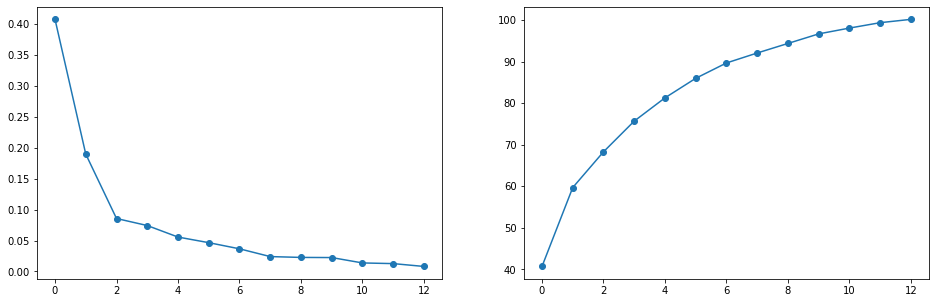

In [16]:
cumsum = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
ax[0].plot(pca.explained_variance_ratio_, '-o')
ax[1].plot(cumsum, '-o')
plt.show()

=> The fig on the left side illustrates the variance of each principal component and the fig on the right hand side is the cummulative sum of these principal components. It can be seen from the plot that even the first 4 principal component explains around 75 percent

 ### <font color=blue>**3. Fit and transform with 70% of variance**

In [21]:
pca = PCA(n_components=0.7)
X_pca = pca.fit_transform(X)
pca.n_components_, np.sum(pca.explained_variance_ratio_)

(4, 0.7570818476302283)

In [22]:
X_recovered_pca = pca.inverse_transform(X_pca)
X_recovered_pca

array([[0.74971077, 0.21582276, 0.58656014, ..., 0.49825537, 0.77958809,
        0.64274717],
       [0.60858142, 0.09584649, 0.4086393 , ..., 0.51101544, 0.64189811,
        0.50266736],
       [0.67649544, 0.31785858, 0.6523808 , ..., 0.45882894, 0.75458262,
        0.54173685],
       ...,
       [0.73200401, 0.66317021, 0.57351016, ..., 0.04443922, 0.08190511,
        0.36306196],
       [0.69004262, 0.44134629, 0.60236532, ..., 0.20184317, 0.08900233,
        0.40489668],
       [0.68651025, 0.7117156 , 0.75961211, ..., 0.08748039, 0.12932977,
        0.33510892]])

 ### <font color=blue>**4. Plot PCA data with 2 components**

Text(0, 0.5, 'Principal component 2')

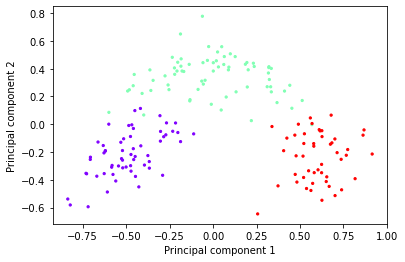

In [156]:
PCA_df = pd.DataFrame(pca.transform(X[selected_vars]))

cmap = ListedColormap(y)
# Show cluster in 2D space
plt.scatter(PCA_df.iloc[:,0], PCA_df.iloc[:,1], s=5, c=y, cmap = plt.cm.rainbow)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

 ### <font color=blue>**5. Interpretation of principle components**

In [158]:
df_comp

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,-0.133368,0.248516,-0.000739,0.177839,-0.088657,-0.395071,-0.414590,0.333109,-0.252902,0.092329,-0.251137,-0.473492,-0.286862
1,-0.550884,-0.227391,-0.163091,0.079776,-0.188166,-0.074145,-0.001007,-0.009960,-0.031418,-0.519707,0.237206,0.215562,-0.443888
2,-0.083848,0.492039,0.403009,0.477242,0.006551,0.253065,0.196105,0.285982,0.228342,-0.033100,-0.106589,0.297776,-0.151968
3,-0.040328,0.486032,-0.241976,-0.081694,0.015880,-0.052643,-0.027033,-0.709095,0.076574,-0.026322,-0.352498,0.082062,-0.229793


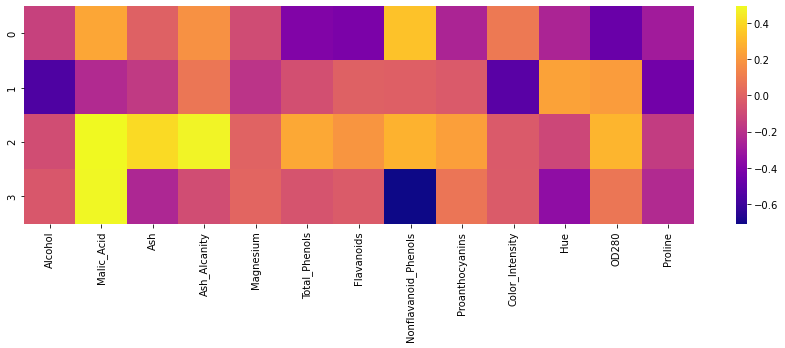

In [157]:
df_comp = pd.DataFrame(pca.components_,columns=selected_vars)
plt.figure(figsize=(15,4))
sns.heatmap(df_comp.iloc[0:4,:],cmap='plasma',)
plt.show()

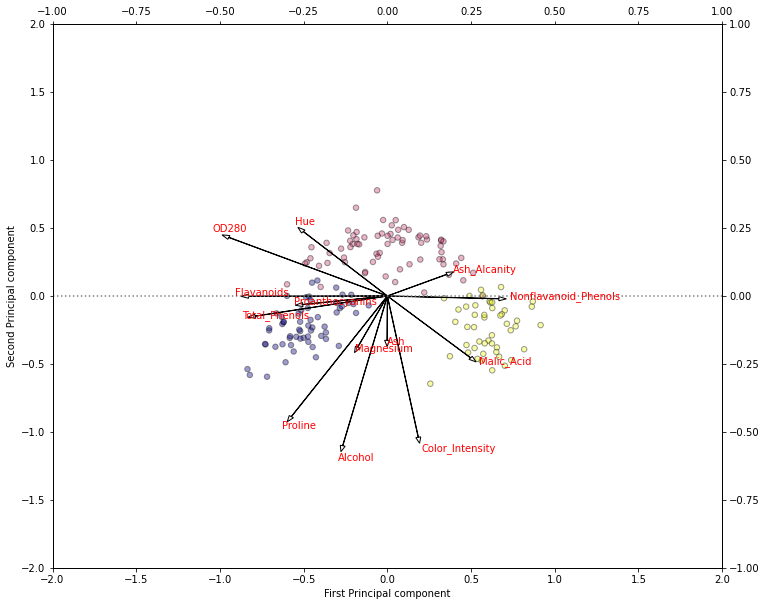

In [177]:
# put feature values into data frame
components = df_comp.T[[0,1]]

# plot size
plt.figure(figsize=(12,10))

# main scatter plot
plt.scatter(PCA_df[0],PCA_df[1],c=y,cmap='plasma',alpha=0.4,edgecolors='black',s=30)
plt.xlabel('First Principal component')
plt.ylabel('Second Principal component')
plt.ylim(-2,2)
plt.xlim(-2,2)

# individual feature values
ax2 = plt.twinx().twiny()
ax2.set_ylim(-1,1)
ax2.set_xlim(-1,1)

# reference lines
ax2.hlines(0,-1,1,linestyles='dotted',colors='grey')
# offset for labels
offset = 1.1

# arrow & text
for a,i in enumerate(components.index):
    ax2.arrow(0, 0, components[0][a], components[1][a], facecolor='white', head_width=.015)
    ax2.annotate(i, (components[0][a]*offset, components[1][a]*offset),color='red')

## <font color=red>**4.2.TSNE**</font>

1. t-Distributed Stochastic Neighbor Embedding (t-SNE) is **a non-linear technique for dimensonality reduction** that is particularly well suited for the visualization of high-dimensional datasets. **t-SNE gives us a feel or intuition of how the data is arranged in a high-dimensional space**. 


2. The idea of TSNE is **t-SNE minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding**. In this way, t-SNE maps the multi-dimensional data to a lower dimensional space and attempts to find patterns in the data by indentifying observed clusters based on similarity of data points with multiple features. However, after this process, the input features are no longer identifiable, and you cannot make any inference based only on the output of t-SNE. Hence it is mainly a data exploration and visualization technique.


3. It is highly recommended to use dimensionality reduction method to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.


4. **t-SNE vs. PCA**
    + PCA is a **linear dimension reduction technique** that seeks to **maximize variance and preserves large pairwise distances**. This can lead to poor visulization especially when dealing with non-linear manifold structures such as any geometric shape like: cylinder, ball, curve, etc.
PCA preserves only the global structure of the data. PCA is concerned with preserving large pairwise distances to maximize variance. 
    + TSNE is a **non-linear dimensionality reduction technique** preserves both the local and global structure. It uses the local relationship between data to map the high-dimensional data in two dimensions, **preserving only small pairwise distances or local similarities**. 

 ### <font color=blue>**1. Train model**

Text(0, 0.5, 'TSNE 2')

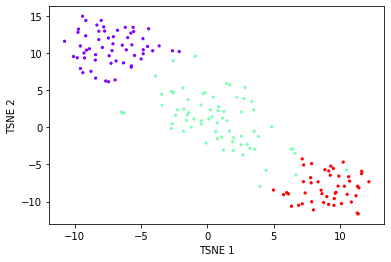

In [28]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=9)
tsne_data = tsne.fit_transform(X[selected_vars])

plt.scatter(tsne_data[:,0], tsne_data[:,1], s=5, c=y, cmap=plt.cm.rainbow)
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')

## <font color=red>**4.3. SVD**</font>

 ### <font color=blue>**1. Train model**

In [160]:
U, S, V = np.linalg.svd(X)
S[0:10]

array([20.35043776,  5.82964479,  3.94740632,  2.70898464,  2.30661666,
        2.12962934,  1.87739348,  1.64518626,  1.47963707,  1.46751136])

 ### <font color=blue>**2. Select number of latent vars**

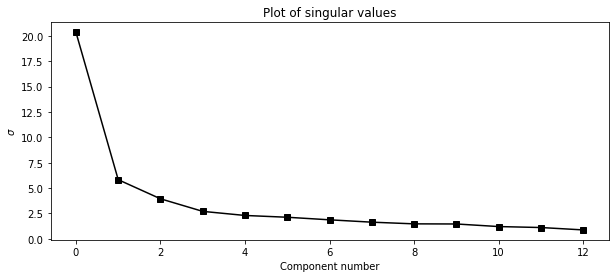

In [161]:
plt.figure(figsize=(10,4))
plt.plot(S, 'ks-')
plt.xlabel('Component number')
plt.ylabel('$\sigma$')
plt.title('Plot of singular values');

In [162]:
# list the components you want to use for the reconstruction
n_comps = np.arange(0,2)

# reconstruct the low-rank version of the picture
X_pred = U[:,n_comps]@np.diag(S[n_comps])@V[:,n_comps].T

In [163]:
X[0:3]

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933


Text(0, 0.5, 'Principal component 2')

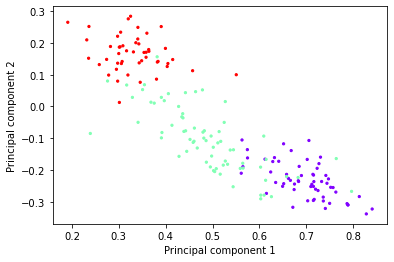

In [164]:
plt.scatter(X_pred[:,0], X_pred[:,1], s=5, c=y, cmap = plt.cm.rainbow)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

# <div class="alert alert-info"> 5. Clustering </div>

In [23]:
cluster_df = pd.DataFrame()
cluster_df['y'] = y

 ## <font color=red>**5.1. KMeans**</font>
 
The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest
1.	Choose the number of clusters, K stands for the number of clusters
2.	Select randomly k objects from the dataset as the initial cluster centers or means
3.	Calculate Euclidean distance between each point and each cluster (centroid), then assign datapoint to the closet centroid
4.	Adjust/Recalculate the centroids: For each of the k clusters update the cluster centroid by calculating the new mean values of all the data points in the cluster
5.	Repeat the last two steps until we can no longer assign the point to a centroid: Iteratively minimize the total within sum of square in a given cluster. That is, iterate until the cluster assignments stop changing or the maximum number of iterations is reached

 ### <font color=blue>**1. Specifying the optimal number of clusters with Elbow method**</font>

In [24]:
from sklearn.cluster import KMeans

n_clusters = 10
kmeans_per_k = [KMeans(n_clusters=k, random_state=0, init='k-means++').fit(X) for k in range(1, n_clusters)]
wcss = [model.inertia_ for model in kmeans_per_k]

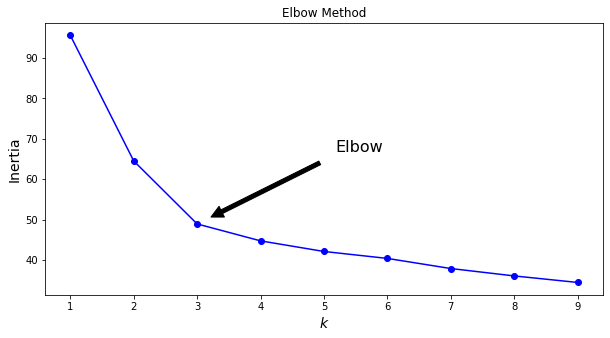

In [25]:
plt.figure(figsize=(10,5))
plt.plot(range(1,10), wcss, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.title('Elbow Method')
plt.annotate('Elbow',
             xy=(3, wcss[2]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
        )
plt.show()

=> There is an elbow at k = 3, which means that less clusters than that would be bad, and more clusters would not help much. 

 ### <font color=blue>**2. Specifying the number of clsuters with Silhoute score**
    
Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

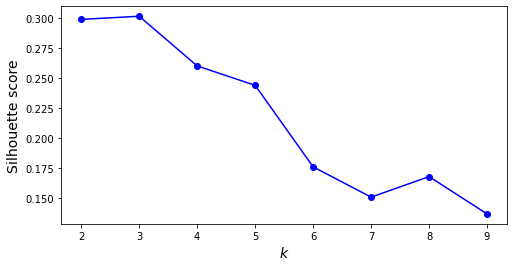

In [26]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

This visualization confirms that $k=3$ has highest Silhouette score, so it is a very good choice

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

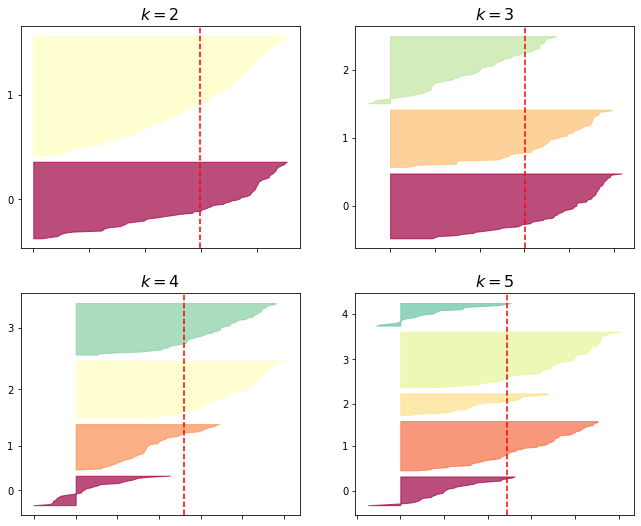

In [27]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2,3,4,5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (8, 10):
        plt.ylabel("Cluster")
    
    if k in (10, 12):
        plt.gca().set_xticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
plt.show()

As suggested from the plot, $k=3$ looks like the best option here, as all clusters are roughly the same size, and they all cross the dashed line, which represents the mean silhouette score.

 ### <font color=blue>**3. Train model**</font>

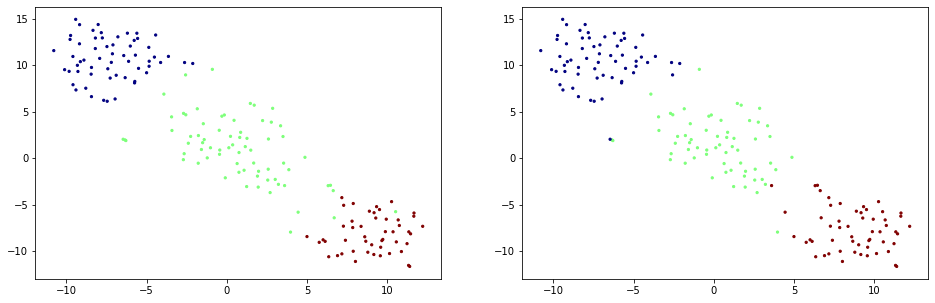

In [29]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3)
km.fit(X)
km.predict(X)
cluster_df['KMeans'] = km.labels_
cluster_class = mapping_cluster_class(y, cluster_df['KMeans'])
cluster_df['KMeans'] = cluster_df['KMeans'].map(cluster_class)
plot_cluster(tsne_data, y, cluster_df['KMeans'])

#### clusters

In [30]:
km.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2, 2,
       2, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

#### centroids

In [32]:
km.cluster_centers_[0:3]

array([[0.544689  , 0.47844053, 0.56013612, 0.53833177, 0.31146245,
        0.24476489, 0.10713464, 0.61852487, 0.22827646, 0.4826404 ,
        0.19254989, 0.16090576, 0.24739982],
       [0.70565142, 0.24842869, 0.58490401, 0.3444313 , 0.41072701,
        0.64211419, 0.55467939, 0.30034024, 0.47727155, 0.35534046,
        0.47780888, 0.69038612, 0.59389397],
       [0.31137521, 0.23689915, 0.47291703, 0.49991686, 0.2477209 ,
        0.45305895, 0.38240098, 0.4117468 , 0.39742546, 0.14773478,
        0.47351167, 0.58897554, 0.15640099]])

#### inertia metric

In [33]:
km.inertia_

48.960517136676465

In [34]:
from sklearn.metrics import silhouette_score
silhouette_score(X, km.labels_)

0.3008938518500134

 ### <font color=blue>**4. Hard clustering vs. Soft clustering**

Instead of assigning each instance to a single cluster, which is called hard clustering, it can be useful just give each instance a score per cluster - this is called soft clustering. The score can be distance between the instance and the centroid

In [35]:
X_new = X[0:3]
km.transform(X_new)

array([[1.33793487, 0.40967476, 0.98628955],
       [1.1677189 , 0.4716608 , 0.76006307],
       [1.16333327, 0.36880509, 0.81350307]])

 ## <font color=red>**5.2. Gaussian Mixture Model**</font>

 ### <font color=blue>**1. Train model**</font>

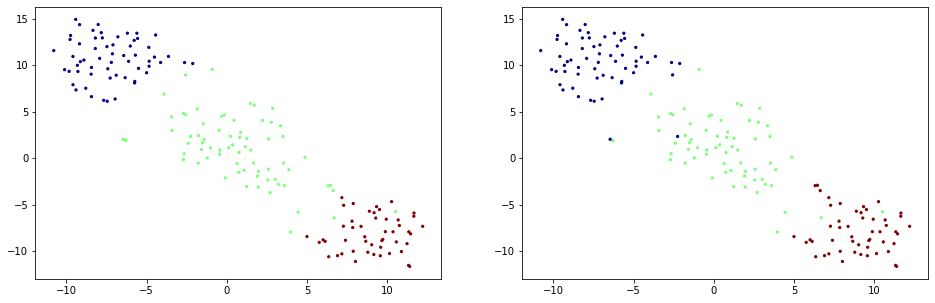

In [37]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=10, random_state=9)
gmm.fit(X)
gmm_prob = gmm.predict_proba(X)
cluster_df['GMM'] = gmm.predict(X)
cluster_class = mapping_cluster_class(y, cluster_df['GMM'])
cluster_df['GMM'] = cluster_df['GMM'].map(cluster_class)
plot_cluster(tsne_data, y, cluster_df['GMM'])

#### Parameters values

In [38]:
gmm.weights_

array([0.36631957, 0.34716488, 0.28651555])

In [39]:
gmm.means_

array([[0.31766496, 0.24540055, 0.47144959, 0.49956639, 0.24480749,
        0.43540097, 0.37079481, 0.43099582, 0.39152302, 0.14976605,
        0.46201505, 0.56818326, 0.15746421],
       [0.70223232, 0.24786544, 0.58321609, 0.34547268, 0.40762967,
        0.63925352, 0.55347444, 0.29969498, 0.47660368, 0.35363791,
        0.47878418, 0.69026227, 0.59017629],
       [0.55294167, 0.48701948, 0.56915219, 0.54295599, 0.32139787,
        0.25152126, 0.09915596, 0.61265253, 0.22211954, 0.5051374 ,
        0.18396234, 0.15248173, 0.25085995]])

Did the algorithm actually converge?

In [40]:
gmm.converged_

True

Yes, good. How many iterations did it take?

In [41]:
gmm.n_iter_

9

 ### <font color=blue>**2.  Specify number of clusters with BIC, AIC**</font>

**BIC, AIC**

In [42]:
gmm.bic(X),  gmm.aic(X)

(-1695.6618051016999, -2694.7418398934146)

In [43]:
n_clusters = 3
n_dims = 13
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gmm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

bic, aic, n_params

(-1695.6618051016999, -2694.7418398934146, 314)

There's one weight per cluster, but the sum must be equal to 1, so we have one degree of freedom less, hence the -1. Similarly, the degrees of freedom for an $n \times n$ covariance matrix is not $n^2$, but $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Let's train Gaussian Mixture models with various values of $k$ and measure their BIC:

In [44]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=9).fit(X) for k in range(1, 6)]

bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

bics

[-1744.2912486476619,
 -1856.0184831103752,
 -1695.6618051016999,
 -1472.5520165883913,
 -1348.6035099738083]

In [46]:
aics

[-2075.1967378780387,
 -2521.011245121421,
 -2694.7418398934146,
 -2805.719324160775,
 -3015.8580903268607]

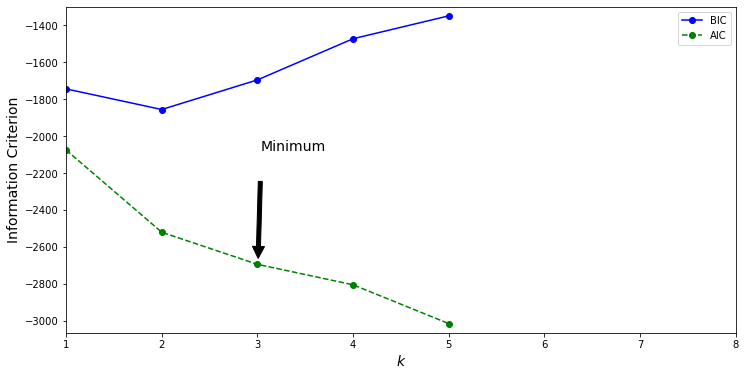

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 6), bics, "bo-", label="BIC")
plt.plot(range(1, 6), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 8, np.min(aics) - 50, np.max(bics) + 50])
plt.annotate('Minimum',
             xy=(3, aics[3]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.2)
            )
plt.legend()
plt.show()

 ### <font color=blue>**3.  Specify number of clusters with lower bound**</font>

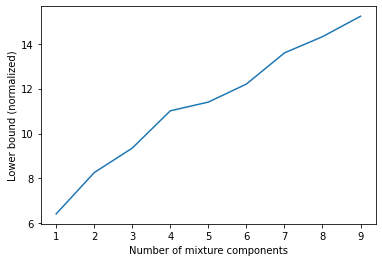

In [48]:
from sklearn.mixture import GaussianMixture
Cs = range(1,10)
lbs = []

for C in Cs:
    gmm = GaussianMixture(n_components=C, n_init=10)
    gmm.fit(X)
    lbs.append(gmm.lower_bound_)
    
plt.plot(Cs, lbs)
plt.xlabel("Number of mixture components")
plt.ylabel("Lower bound (normalized)");

 ## <font color=red>**5.3. Hierarchical Clustering**</font>

 ### <font color=blue>**1. Dendrogram**</font>

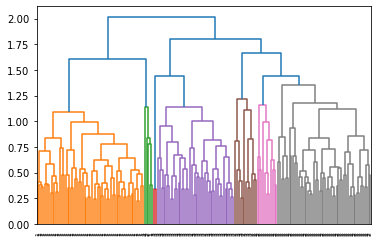

In [49]:
from scipy.cluster.hierarchy import linkage, dendrogram

mergings = linkage(X, method='complete')

dendrogram(mergings, labels=list(y), leaf_rotation=90, leaf_font_size=6);

 ### <font color=blue>**2. Train model**</font>

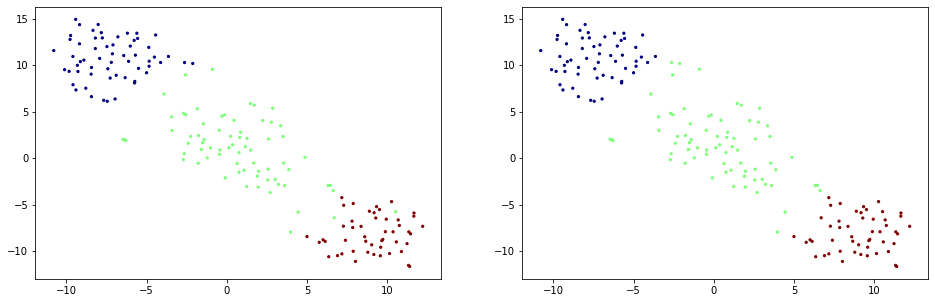

In [50]:
agg = clu.AgglomerativeClustering(3)
agg.fit(X)
cluster_df['Agg'] = agg.fit_predict(X)
cluster_class = mapping_cluster_class(y, cluster_df['Agg'])
cluster_df['Agg'] = cluster_df['Agg'].map(cluster_class)
plot_cluster(tsne_data, y, cluster_df['Agg'])

 ## <font color=red>**5.4. DBSCAN Clustering**</font>

 ### <font color=blue>**1. Train model**</font>

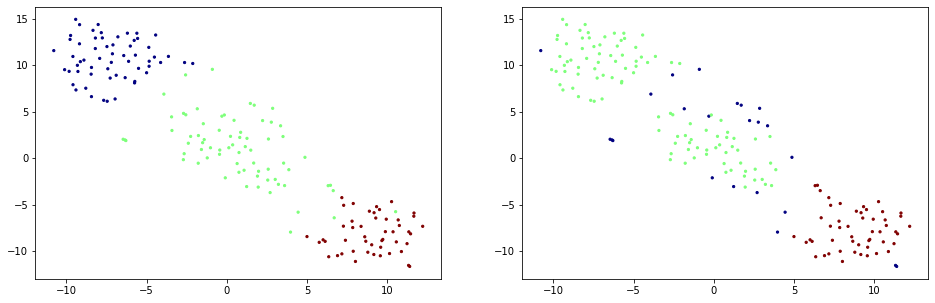

In [121]:
from sklearn.cluster import DBSCAN

# Declaring Model
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fitting
cluster_df['dbs'] = dbscan.fit_predict(X)
#cluster_df.loc[cluster_df.dbs == -1,'dbs'] = 2 
cluster_class = mapping_cluster_class(y, cluster_df['dbs'])
#cluster_df['dbs'] = cluster_df['dbs'].map(cluster_class)
plot_cluster(tsne_data, y, cluster_df['dbs'])

In [108]:
np.unique(dbscan.labels_)

array([-1,  0,  1], dtype=int64)

In [109]:
cluster_df['dbs'].value_counts()

 0    100
 1     43
-1     35
Name: dbs, dtype: int64

In [110]:
len(dbscan.core_sample_indices_)

84

In [111]:
dbscan.core_sample_indices_[:10]

array([ 0,  1,  2,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [112]:
dbscan.components_[:3]

array([[0.84210526, 0.1916996 , 0.57219251, 0.25773196, 0.61956522,
        0.62758621, 0.57383966, 0.28301887, 0.59305994, 0.37201365,
        0.45528455, 0.97069597, 0.56134094],
       [0.57105263, 0.2055336 , 0.4171123 , 0.03092784, 0.32608696,
        0.57586207, 0.51054852, 0.24528302, 0.27444795, 0.26450512,
        0.46341463, 0.78021978, 0.55064194],
       [0.56052632, 0.3201581 , 0.70053476, 0.41237113, 0.33695652,
        0.62758621, 0.61181435, 0.32075472, 0.75709779, 0.37542662,
        0.44715447, 0.6959707 , 0.64693295]])

In [113]:
dbscan.components_.shape

(84, 13)

 ### <font color=blue>**2. Find parameters**</font>

In [122]:
dbscan2 = DBSCAN(eps=0.5, min_samples=5)
dbscan2.fit(X)

DBSCAN()

In [123]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

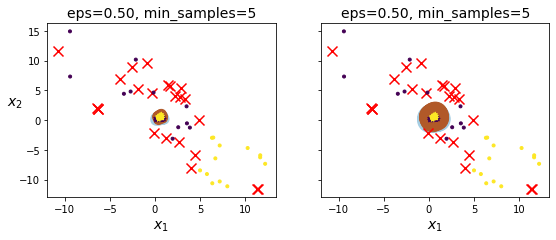

In [124]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, tsne_data, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, tsne_data, size=600, show_ylabels=False)

plt.show()

 ## <font color=red>**5.5. SOM**</font>

 ### <font color=blue>**1. Train model**</font>

In [147]:
# Training the SOM
from minisom import MiniSom
som = MiniSom(x = 50, y = 50, input_len = 13, sigma = 50, learning_rate = 0.01)
som.random_weights_init(X.values)
som.train_random(data = X.values, num_iteration = 500)

 ### <font color=blue>**2. Visualize results**</font>

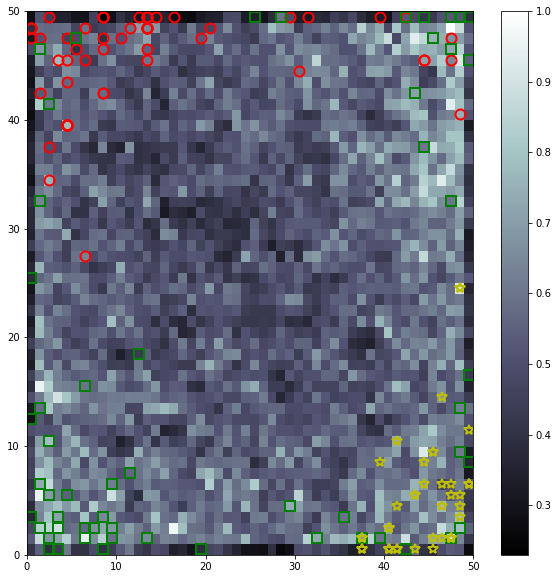

In [148]:
plt.figure(figsize=(10,10))
# Visualizing the results
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's', '*']
colors = ['r', 'g', 'y']
for i, x in enumerate(X.values):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]-1],
         markeredgecolor = colors[y[i]-1],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

# <div class="alert alert-info"> 6.  Try with other algorithms </div>

 ## <font color=red>**6.1. Original data**</font>

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


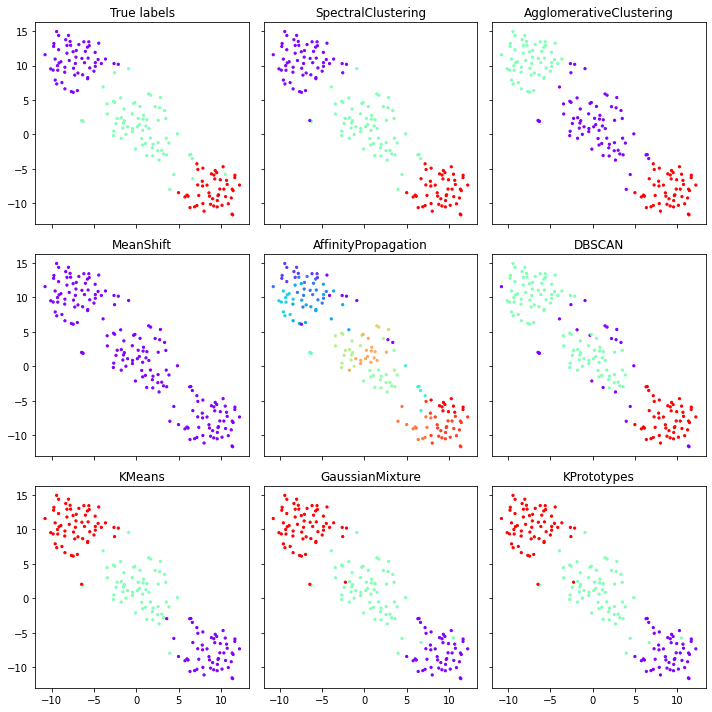

In [150]:
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)
axes[0, 0].scatter(tsne_data[:,0], tsne_data[:,1], s=5, c=y, cmap=plt.cm.rainbow)
axes[0, 0].set_title("True labels")

for ax, est in zip(axes.flat[1:], [
    clu.SpectralClustering(3),
    clu.AgglomerativeClustering(3),
    clu.MeanShift(),
    clu.AffinityPropagation(),
    clu.DBSCAN(),
    clu.KMeans(3),
    GaussianMixture(n_components=3, n_init=10),
    KPrototypes(n_clusters= 3, init='Cao')
]):
    # est.fit(X_data)
    if(est.__class__.__name__ != 'KPrototypes'):
        c = relabel(est.fit_predict(X[selected_vars]))
    #else:
        c = relabel(est.fit_predict(X[selected_vars]))
    ax.scatter(tsne_data[:,0], tsne_data[:,1], s=5, c=c, cmap=plt.cm.rainbow)
    ax.set_title(est.__class__.__name__)

fig.tight_layout()

 ## <font color=red>**6.2. PCA data**</font>

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


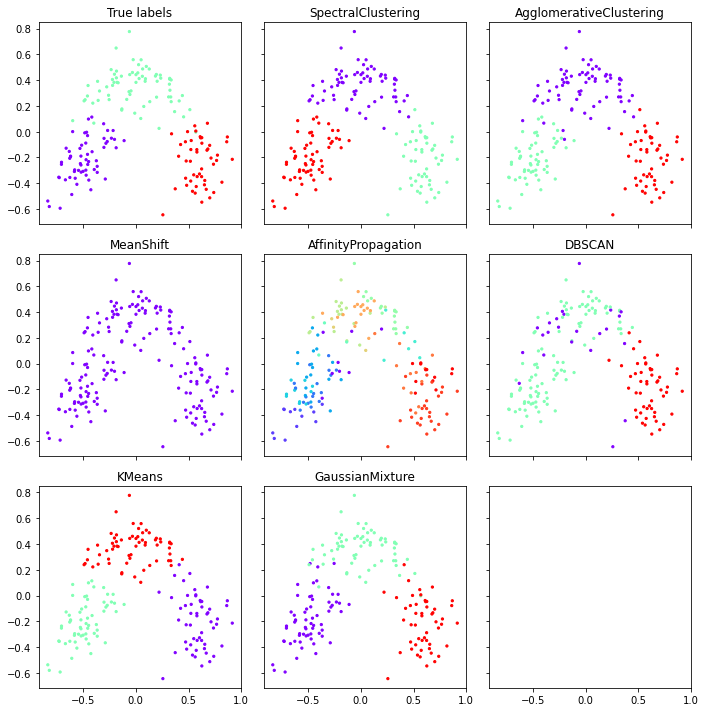

In [155]:
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)


axes[0, 0].scatter(PCA_df.iloc[:,0], PCA_df.iloc[:,1], s=5, c=y, cmap=plt.cm.rainbow)
axes[0, 0].set_title("True labels")

for ax, est in zip(axes.flat[1:], [
    clu.SpectralClustering(3),
    clu.AgglomerativeClustering(3),
    clu.MeanShift(),
    clu.AffinityPropagation(),
    clu.DBSCAN(),
    clu.KMeans(3),
    GaussianMixture(n_components=3, n_init=10),
    #KPrototypes(n_clusters= 3, init='Cao')
]):
    # est.fit(X_data)
    if(est.__class__.__name__ != 'KPrototypes'):
        c = relabel(est.fit_predict(X[selected_vars]))
    #else:
        #c = relabel(est.fit_predict(X[selected_vars]))
    ax.scatter(PCA_df.iloc[:,0], PCA_df.iloc[:,1], s=5, c=c, cmap=plt.cm.rainbow)
    ax.set_title(est.__class__.__name__)

fig.tight_layout()